In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.optimizers import SGD
from IPython.display import display, HTML
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from io import BytesIO
import cv2
import dlib
import pandas as pd
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


In [12]:
import cv2
import dlib
import pandas as pd
import os
# Load the facial landmark detector
predictor_path = predictor_path = "shape_predictor_68_face_landmarks.dat"  # Download from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor = dlib.shape_predictor(predictor_path)
def extract_features(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use dlib to detect faces
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray)

    features_list = []  # List to store features for each image
    if len(faces) == 0:
        features_list.append([0,0,0,0,0,0,0,0,0])
    else:
        for face in faces:
            shape = predictor(gray, face)
            # Extract features
            eyebrow_indices = list(range(17, 27))
            eyebrow_points = [(shape.part(i).x, shape.part(i).y) for i in eyebrow_indices]
    
            eye_indices = list(range(36, 42))  # Left eye
            eye_indices += list(range(42, 48))  # Right eye
            eye_points = [(shape.part(i).x, shape.part(i).y) for i in eye_indices]
    
            lip_indices = list(range(48, 60))
            lip_points = [(shape.part(i).x, shape.part(i).y) for i in lip_indices]
    
            # Estimate hair length (distance between top of forehead and bottom of chin)
            forehead_top = min(eyebrow_points[0][1], eyebrow_points[1][1], eyebrow_points[2][1])
            chin_bottom = max(lip_points[6][1], lip_points[7][1], lip_points[8][1])
            face_height = chin_bottom - forehead_top
    
            # Calculate face width and height
            face_width = abs(eyebrow_points[-1][0] - eyebrow_points[0][0])
    
            # Calculate the ratio of face width to face height
            face_ratio = face_width / face_height
    
            # Classify face shape as round (1) or not round (0)
            round_face = 1 if 0.95 <= face_ratio <= 1.05 else 0

            # Additional landmarks for makeup, lipstick, and necktie
            makeup_indices = list(range(27, 35))  # Points around the nose
            makeup_points = [(shape.part(i).x, shape.part(i).y) for i in makeup_indices]

            lipstick_indices = list(range(60, 68))  # Points around the mouth
            lipstick_points = [(shape.part(i).x, shape.part(i).y) for i in lipstick_indices]

            necktie_indices = list(range(0, 17))  # Points around the face outline and neck
            necktie_points = [(shape.part(i).x, shape.part(i).y) for i in necktie_indices]

            # Check if the points related to makeup, lipstick, and necktie are below or above certain thresholds
            makeup_present = 1 if any(point[1] > eyebrow_points[1][1] for point in makeup_points) else 0
            lipstick_present = 1 if any(point[1] > eyebrow_points[1][1] for point in lipstick_points) else 0
            necktie_present = 1 if any(point[1] > eyebrow_points[1][1] for point in necktie_points) else 0
            
            a = abs(eyebrow_points[-1][0] - eyebrow_points[0][0])
            b = abs(eyebrow_points[0][1] - eyebrow_points[4][1])
            c = abs(eye_points[3][0] - eye_points[0][0])
            d = abs(lip_points[-1][0] - lip_points[0][0])
            e = face_height
            f = round_face
            features_list.append([a,b,c,d,e,f,makeup_present, lipstick_present, necktie_present])
    return features_list

In [2]:
path =  '../Unzipped/img_align_celeba/img_align_celeba/'
main_folder = "../UnZipped/"

In [3]:
df_attr = pd.read_csv('../Unzipped/list_attr_celeba/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)  # replace -1 by 0
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [4]:
df_partition = pd.read_csv(main_folder + '/list_eval_partition/list_eval_partition.csv')
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [5]:
def generate_subset_data(attr, num_samples, train_size, test_size):
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for partition in [0, 1, 2]:  # Train, Validation, Test
        # Separate positive and negative samples
        positive_samples = df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 1)].sample(int(num_samples / 2))
        negative_samples = df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 0)].sample(int(num_samples / 2))

        # Shuffle positive and negative samples separately
        positive_samples = positive_samples.sample(frac=1)
        negative_samples = negative_samples.sample(frac=1)

        # Concatenate shuffled positive and negative samples
        df_ = pd.concat([positive_samples, negative_samples])

        for i, (index, target) in enumerate(df_.iterrows()):
            if partition != 2:  # Train or Validation
                if i < train_size:
                    train_x.append(index)
                    train_y.append(target[attr])
                else:
                    test_x.append(index)
                    test_y.append(target[attr])
            else:  # Test
                test_x.append(index)
                test_y.append(target[attr])

    # Ensure the number of samples in test_x and test_y are the same
    min_samples = min(len(test_x), len(test_y))
    test_x = test_x[:min_samples]
    test_y = test_y[:min_samples]

    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)


In [6]:
# Generate a smaller subset of data
attr_to_test = 'Male'  # Choose the attribute you want to test
num_samples_to_test = 500  # Choose the total number of samples to use in the subset
train_size_to_test = 400 # Choose the number of samples for training
test_size_to_test = num_samples_to_test - train_size_to_test

# Generate the subset
train_x, train_y, test_x, test_y = generate_subset_data(attr_to_test, num_samples_to_test, train_size_to_test, test_size_to_test)

# Print the shapes of the generated data
print("Train data shape:", train_x.shape)
print("Train labels shape:", train_y.shape)
print("Test data shape:", test_x.shape)
print("Test labels shape:", test_y.shape)

Train data shape: (800,)
Train labels shape: (800,)
Test data shape: (700,)
Test labels shape: (700,)


In [13]:
def arrayconverter(image_list):
    data_list = []
    for index in image_list:
        image_path = path + index
        features_list = extract_features(image_path)

        for features in features_list:
            data_list.append({
                'Eyebrow_Width': features[0],
                'Eyebrow_Length': features[1],
                'Eye_Length': features[2],
                'Lip_Size': features[3],
                'Face_Length': features[4],
                'Round_Face': features[5],
                'Make_Up': features[6],
                'Lipstick': features[7],
                'Necktie': features[8]
            })
    
    # Convert the list of dictionaries to a Pandas DataFrame
    dataframe = pd.DataFrame(data_list)

    # Convert the DataFrame to a NumPy array
    numpy_array = dataframe.to_numpy()
    return numpy_array

In [14]:
train_x = arrayconverter(train_x)
test_x = arrayconverter(test_x)

In [15]:
# Print the shapes of the generated data
print("Train data shape:", train_x.shape)
print("Train labels shape:", train_y.shape)
print("Test data shape:", test_x.shape)
print("Test labels shape:", test_y.shape)

Train data shape: (800, 9)
Train labels shape: (800,)
Test data shape: (700, 9)
Test labels shape: (700,)


Accuracy: 61.71%
Sensitivity: 0.8280
Specificity: 0.5000
AUC: 0.7565


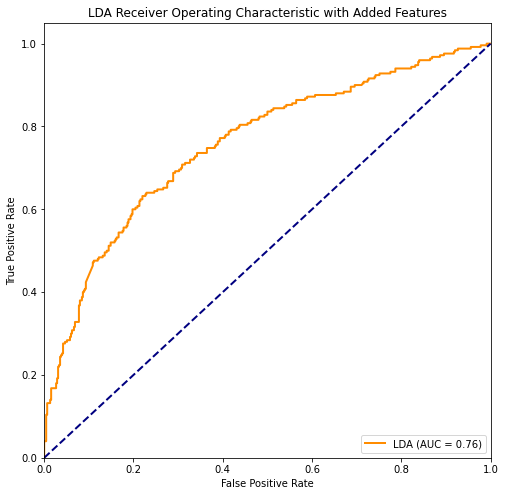

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# # Ensure the number of samples in test_y and lda_predictions are the same
# min_samples = min(len(test_y), len(lda_predictions))
# test_y = test_y[:min_samples]
# lda_predictions = lda_predictions[:min_samples]

# # Evaluate the model
# accuracy_lda = accuracy_score(test_y, lda_predictions)
# print(f'Accuracy: {accuracy_lda * 100:.2f}%')


# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(train_x, train_y)
lda_scores = lda.predict_proba(test_x)[:, 1]

# Convert probabilities to binary predictions
lda_predictions = (lda_scores > 0.5).astype(int)

# Evaluate the model
accuracy_lda = accuracy_score(test_y, lda_predictions)
print(f'Accuracy: {accuracy_lda * 100:.2f}%')

# Calculate confusion matrix
conf_matrix_lda = confusion_matrix(test_y, lda_predictions)

# Calculate sensitivity (true positive rate)
sensitivity_lda = conf_matrix_lda[1, 1] / (conf_matrix_lda[1, 0] + conf_matrix_lda[1, 1])
print(f'Sensitivity: {sensitivity_lda:.4f}')

# Calculate specificity (true negative rate)
specificity_lda = conf_matrix_lda[0, 0] / (conf_matrix_lda[0, 0] + conf_matrix_lda[0, 1])
print(f'Specificity: {specificity_lda:.4f}')

# Calculate AUC
auc_score_lda = roc_auc_score(test_y, lda_scores)
print(f'AUC: {auc_score_lda:.4f}')

# Calculate ROC curve and AUC for LDA
fpr_lda, tpr_lda, _ = roc_curve(test_y, lda_scores)
roc_auc_lda = auc(fpr_lda, tpr_lda)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_lda, tpr_lda, color='darkorange', lw=2, label=f'LDA (AUC = {roc_auc_lda:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LDA Receiver Operating Characteristic with Added Features')
plt.legend(loc='lower right')
plt.show()


c:\Users\ramya\anaconda3\envs\MyPythonData\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 57.86%
Sensitivity: 0.6360
Specificity: 0.5467
AUC: 0.5913


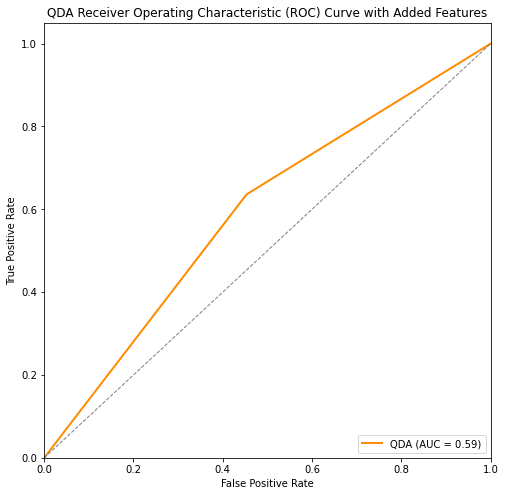

In [17]:
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(train_x, train_y)

#train_x, train_y, test_x, test_y

#Make Predictions
qda_probs = qda.predict(test_x)

# Evaluate the model
accuracy = accuracy_score(test_y, qda_probs)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_y, qda_probs)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Sensitivity: {sensitivity:.4f}')

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Specificity: {specificity:.4f}')

# Calculate AUC
auc_score = roc_auc_score(test_y, qda_probs)
print(f'AUC: {auc_score:.4f}')

fpr_qda, tpr_qda, _ = roc_curve(test_y, qda_probs)
roc_auc_qda = auc(fpr_qda, tpr_qda)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_qda, tpr_qda, color='darkorange', lw=2, label=f'QDA (AUC = {roc_auc_qda:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('QDA Receiver Operating Characteristic (ROC) Curve with Added Features')
plt.legend(loc="lower right")
plt.show()


Accuracy: 0.5786
Confusion Matrix:
[[226 224]
 [ 71 179]]
Sensitivity: 0.7160
Specificity: 0.5022


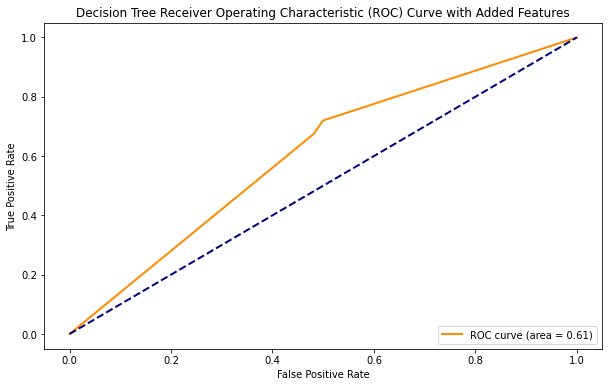

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn import datasets

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier on the training data
dt_classifier.fit(train_x, train_y)

# Make predictions on the test data
predictions = dt_classifier.predict(test_x)

# Evaluate the performance
accuracy = accuracy_score(test_y, predictions)
conf_matrix = confusion_matrix(test_y, predictions)
print(f'Accuracy: {accuracy:.4f}')

print('Confusion Matrix:')
print(conf_matrix)

# Calculate sensitivity and specificity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

# Get decision function scores
decision_scores = dt_classifier.predict_proba(test_x)[:, 1]

# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, decision_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curve with Added Features')
plt.legend(loc='lower right')
plt.show()

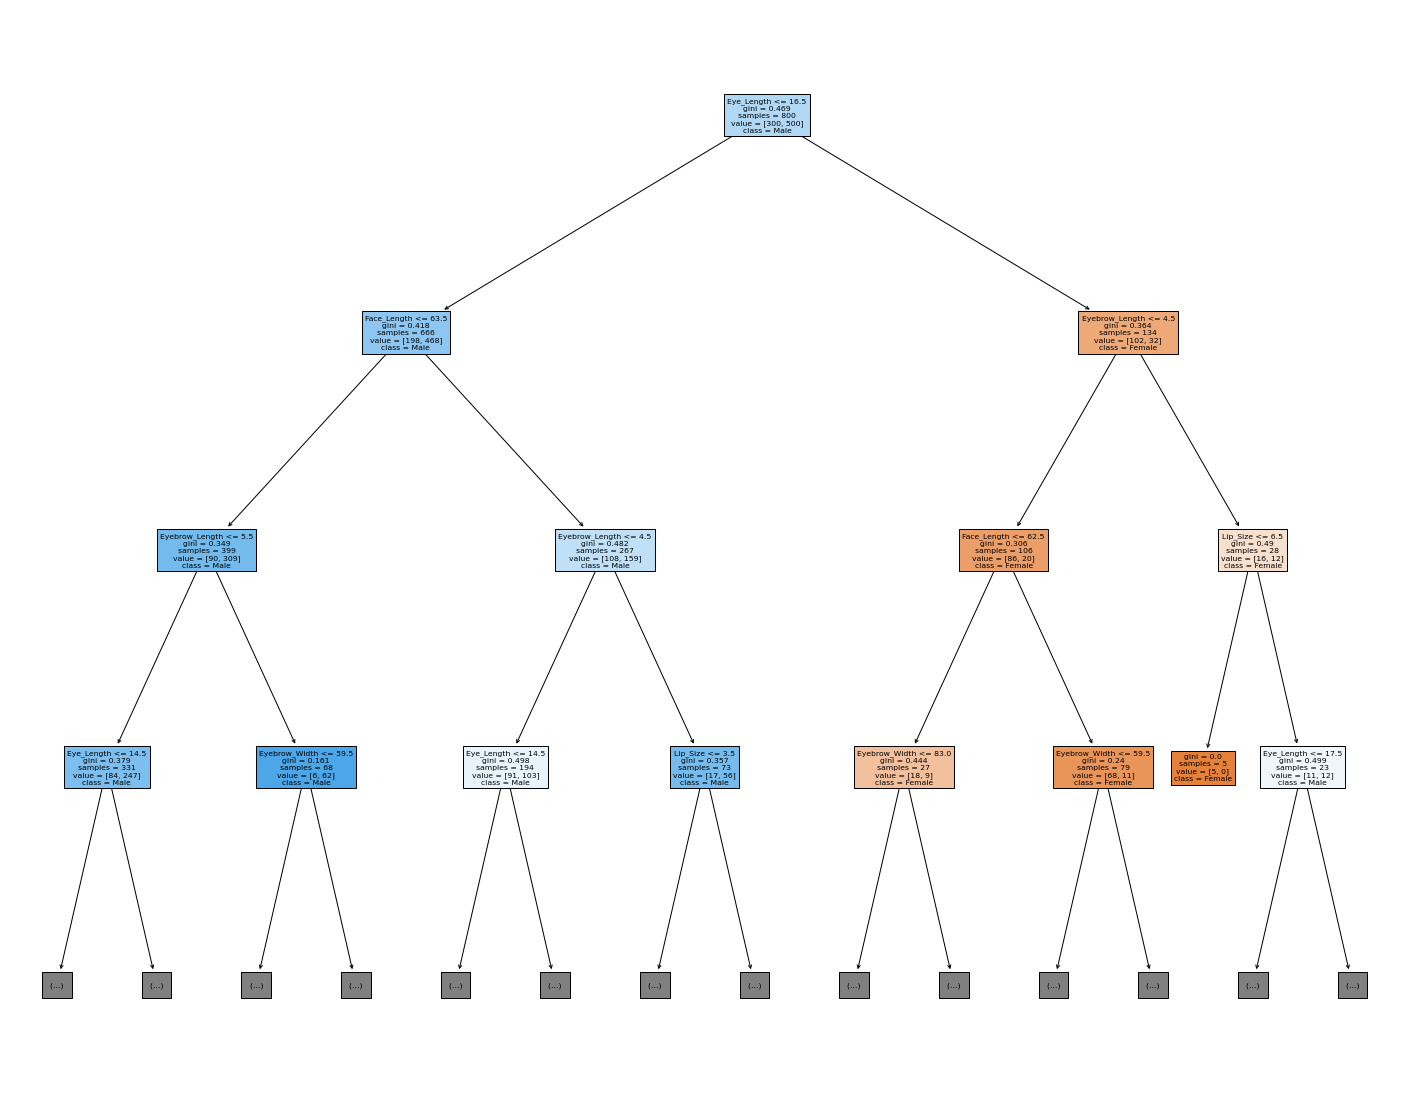

In [23]:
from sklearn import tree
column_names = ['Eyebrow_Width', 'Eyebrow_Length', 'Eye_Length', 'Lip_Size', 'Face_Length', 'Round_Face', 'Make_up', 'Lipstick', 'Necktie']
fig = plt.figure(figsize = (25,20))
tree.plot_tree(dt_classifier,max_depth = 3, feature_names = column_names, class_names= ['Female','Male'], filled=True)
plt.show()

Confusion Matrix:
[[198 252]
 [ 61 189]]
Accuracy: 0.5528571428571428
Sensitivity: 0.7560
Specificity: 0.4400
AUC: 0.5980


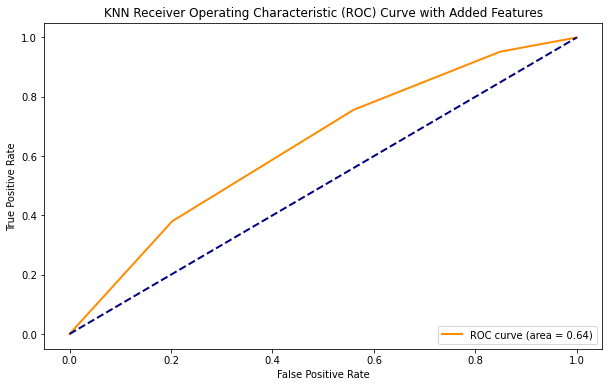

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score


# Initialize the KNN classifier with the desired number of neighbors (e.g., 3)
knn_classifier = KNeighborsClassifier(n_neighbors=21)

# Train the classifier on the training data
knn_classifier.fit(train_x, train_y)

# Make predictions on the test data
predictions = knn_classifier.predict(test_x)

# Evaluate the performance
accuracy = accuracy_score(test_y, predictions)
conf_matrix = confusion_matrix(test_y, predictions)

print('Confusion Matrix:')
print(conf_matrix)

print("Accuracy:", accuracy)

# Calculate sensitivity and specificity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, knn_classifier.predict_proba(test_x)[:, 1])
roc_auc = auc(fpr, tpr)

# Calculate AUC
auc_score = roc_auc_score(test_y, predictions)
print(f'AUC: {auc_score:.4f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Receiver Operating Characteristic (ROC) Curve with Added Features')
plt.legend(loc='lower right')
plt.show()

Accuracy is 60.14285714285714
Confusion Matrix
[[207 243]
 [ 36 214]]


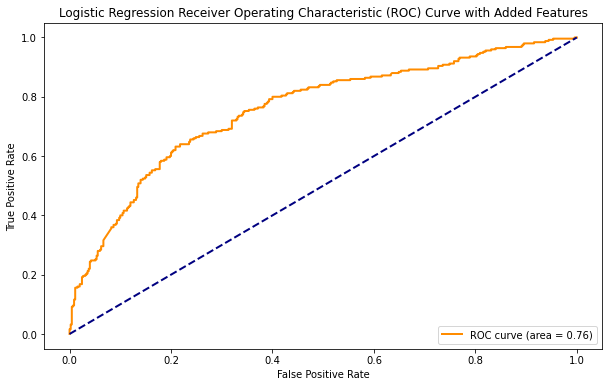

In [20]:
#Import more necessary items for Logistic Regression
from sklearn.datasets import load_wine 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(train_x, train_y)

# Using the model to predict the labels of the test data
pred_y = logistic_model.predict(test_x)

# Evaluating the accuracy of the model using the sklearn functions
accuracy = accuracy_score(test_y,pred_y)*100
confusion_mat = confusion_matrix(test_y,pred_y)

# Printing the results
print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)

# Get decision function scores
decision_scores = logistic_model.decision_function(test_x)

# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, decision_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve with Added Features')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.59
Sensitivity: 0.8480
Specificity: 0.4489
AUC: 0.6484


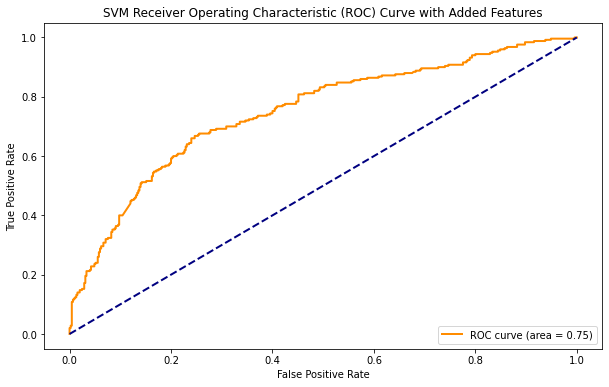

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
# Create a Support Vector Machine model
svm_model = SVC(kernel='linear', C=1.0)

# Train the SVM model
svm_model.fit(train_x, train_y)

# Make predictions on the test set
y_pred = svm_model.predict(test_x)

# Calculate accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

#Calculate confusion matrix
conf_matrix = confusion_matrix(test_y, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Sensitivity: {sensitivity:.4f}')

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Specificity: {specificity:.4f}')

# Calculate AUC
auc_score = roc_auc_score(test_y, y_pred)
print(f'AUC: {auc_score:.4f}')

# Get decision function scores
decision_scores = svm_model.decision_function(test_x)

# Generate ROC curve and calculate AUC
fpr, tpr, thresholds = roc_curve(test_y, decision_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic (ROC) Curve with Added Features')
plt.legend(loc='lower right')
plt.show()

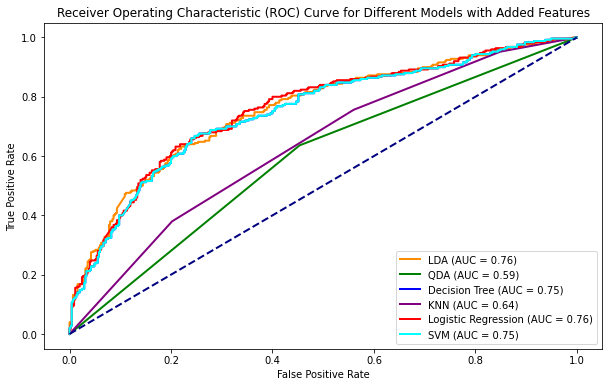

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and AUC for Linear Discriminant Analysis (LDA)
fpr_lda, tpr_lda, _ = roc_curve(test_y, lda_scores)
roc_auc_lda = auc(fpr_lda, tpr_lda)

# Calculate ROC curve and AUC for Quadratic Discriminant Analysis (QDA)
fpr_qda, tpr_qda, _ = roc_curve(test_y, qda_probs)
roc_auc_qda = auc(fpr_qda, tpr_qda)

# Calculate ROC curve and AUC for Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(test_y, decision_scores)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Calculate ROC curve and AUC for KNN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(test_y, knn_classifier.predict_proba(test_x)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Calculate ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_y, logistic_model.decision_function(test_x))
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Calculate ROC curve and AUC for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_y, svm_model.decision_function(test_x))
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curves for all models
plt.figure(figsize=(10, 6))
plt.plot(fpr_lda, tpr_lda, color='darkorange', lw=2, label=f'LDA (AUC = {roc_auc_lda:.2f})')
plt.plot(fpr_qda, tpr_qda, color='green', lw=2, label=f'QDA (AUC = {roc_auc_qda:.2f})')
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_knn, tpr_knn, color='purple', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_svm, tpr_svm, color='cyan', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Different Models with Added Features')
plt.legend(loc='lower right')
plt.show()


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_x)
X_test_scaled = scaler.transform(test_x)


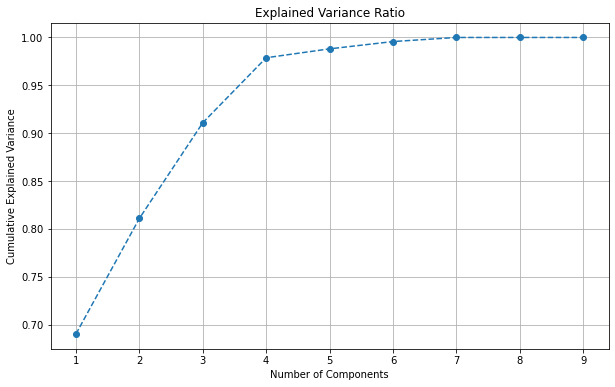

In [26]:
# Apply PCA without specifying the number of components
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Plot the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio with Added Features')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [27]:
# Step 4: Apply PCA
n_components = 4  # You can choose the number of components based on your requirements
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Accuracy: 46.29%
Sensitivity: 0.8720
Specificity: 0.2356
AUC: 0.6600


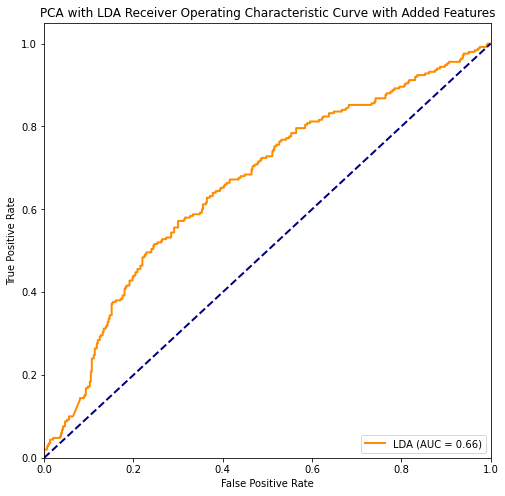

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, train_y)

lda_scores = lda.predict_proba(X_test_pca)[:, 1]

# Convert probabilities to binary predictions
lda_predictions = (lda_scores > 0.5).astype(int)

# Evaluate the model
accuracy_lda = accuracy_score(test_y, lda_predictions)
print(f'Accuracy: {accuracy_lda * 100:.2f}%')

# Calculate confusion matrix
conf_matrix_lda = confusion_matrix(test_y, lda_predictions)

# Calculate sensitivity (true positive rate)
sensitivity_lda = conf_matrix_lda[1, 1] / (conf_matrix_lda[1, 0] + conf_matrix_lda[1, 1])
print(f'Sensitivity: {sensitivity_lda:.4f}')

# Calculate specificity (true negative rate)
specificity_lda = conf_matrix_lda[0, 0] / (conf_matrix_lda[0, 0] + conf_matrix_lda[0, 1])
print(f'Specificity: {specificity_lda:.4f}')

# Calculate AUC
auc_score_lda = roc_auc_score(test_y, lda_scores)
print(f'AUC: {auc_score_lda:.4f}')

# Calculate ROC curve and AUC for LDA
fpr_lda, tpr_lda, _ = roc_curve(test_y, lda_scores)
roc_auc_lda = auc(fpr_lda, tpr_lda)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_lda, tpr_lda, color='darkorange', lw=2, label=f'LDA (AUC = {roc_auc_lda:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA with LDA Receiver Operating Characteristic Curve with Added Features')
plt.legend(loc='lower right')
plt.show()


Accuracy: 53.43%
Sensitivity: 0.7960
Specificity: 0.3889
AUC: 0.5924


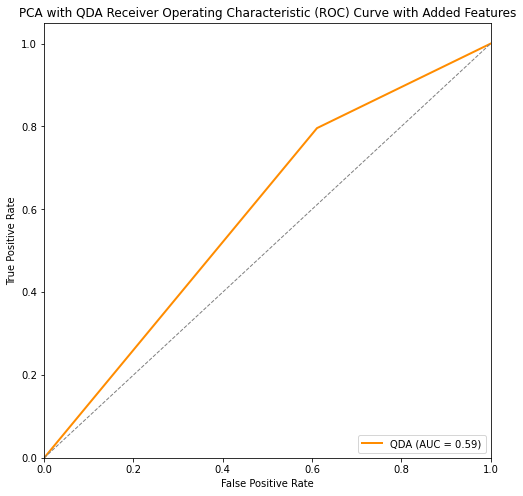

In [35]:
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Perform QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_pca, train_y)

#Make Predictions
qda_probs = qda.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(test_y, qda_probs)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_y, qda_probs)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Sensitivity: {sensitivity:.4f}')

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Specificity: {specificity:.4f}')

# Calculate AUC
auc_score = roc_auc_score(test_y, qda_probs)
print(f'AUC: {auc_score:.4f}')

fpr_qda, tpr_qda, _ = roc_curve(test_y, qda_probs)
roc_auc_qda = auc(fpr_qda, tpr_qda)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr_qda, tpr_qda, color='darkorange', lw=2, label=f'QDA (AUC = {roc_auc_qda:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PCA with QDA Receiver Operating Characteristic (ROC) Curve with Added Features')
plt.legend(loc="lower right")
plt.show()


In [36]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
# Create a Support Vector Machine model
svm_model = SVC(kernel='linear', C=1.0)

# Train the SVM model
svm_model.fit(X_train_pca, train_y)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

#Calculate confusion matrix
conf_matrix = confusion_matrix(test_y, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Sensitivity: {sensitivity:.4f}')

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Specificity: {specificity:.4f}')

# Calculate AUC
auc_score = roc_auc_score(test_y, y_pred)
print(f'AUC: {auc_score:.4f}')

# X has 6 features, but SVC is expecting 4 features as input, thus an error is happening when we try to plot it


# Get decision function scores
# decision_scores = svm_model.decision_function(test_x)

# # Generate ROC curve and calculate AUC
# fpr, tpr, thresholds = roc_curve(test_y, decision_scores)
# roc_auc = auc(fpr, tpr)

# Plot ROC curve
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('PCA with SVM Receiver Operating Characteristic (ROC) Curve with Added Features')
# plt.legend(loc='lower right')
# plt.show()

Accuracy: 0.36
Sensitivity: 1.0000
Specificity: 0.0000
AUC: 0.5000


In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn import datasets

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier on the training data
dt_classifier.fit(X_train_pca, train_y)

# Make predictions on the test data
predictions = dt_classifier.predict(X_test_pca)

# Evaluate the performance
accuracy = accuracy_score(test_y, predictions)
conf_matrix = confusion_matrix(test_y, predictions)
print(f'Accuracy: {accuracy:.4f}')

print('Confusion Matrix:')
print(conf_matrix)

# Calculate sensitivity and specificity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

# X has 6 features, but SVC is expecting 4 features as input, thus an error is happening when we try to plot it


# # Get decision function scores
# decision_scores = dt_classifier.predict_proba(test_x)[:, 1]

# # Generate ROC curve and calculate AUC
# fpr, tpr, thresholds = roc_curve(test_y, decision_scores)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('PCA with Decision Tree Receiver Operating Characteristic (ROC) Curve with Added Features')
# plt.legend(loc='lower right')
# plt.show()

# Calculate AUC
auc_score = roc_auc_score(test_y, y_pred)
print(f'AUC: {auc_score:.4f}')

Accuracy: 0.5300
Confusion Matrix:
[[201 249]
 [ 80 170]]
Sensitivity: 0.6800
Specificity: 0.4467
AUC: 0.5000


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score


# Initialize the KNN classifier with the desired number of neighbors (e.g., 3)
knn_classifier = KNeighborsClassifier(n_neighbors=21)

# Train the classifier on the training data
knn_classifier.fit(X_train_pca, train_y)

# Make predictions on the test data
predictions = knn_classifier.predict(X_test_pca)

# Evaluate the performance
accuracy = accuracy_score(test_y, predictions)
conf_matrix = confusion_matrix(test_y, predictions)

print('Confusion Matrix:')
print(conf_matrix)

print("Accuracy:", accuracy)

# Calculate sensitivity and specificity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

# Calculate AUC
auc_score = roc_auc_score(test_y, y_pred)
print(f'AUC: {auc_score:.4f}')

# X has 6 features, but SVC is expecting 4 features as input, thus an error is happening when we try to plot it

# # Generate ROC curve and calculate AUC
# fpr, tpr, thresholds = roc_curve(test_y, knn_classifier.predict_proba(test_x)[:, 1])
# roc_auc = auc(fpr, tpr)

# # Calculate AUC
# auc_score = roc_auc_score(test_y, predictions)
# print(f'AUC: {auc_score:.4f}')

# # Plot ROC curve
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('PCA with KNN Receiver Operating Characteristic (ROC) Curve with Added Features')
# plt.legend(loc='lower right')
# plt.show()

Confusion Matrix:
[[134 316]
 [ 33 217]]
Accuracy: 0.5014285714285714
Sensitivity: 0.8680
Specificity: 0.2978
AUC: 0.5000


In [44]:
#Import more necessary items for Logistic Regression
from sklearn.datasets import load_wine 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(X_train_pca, train_y)

# Using the model to predict the labels of the test data
pred_y = logistic_model.predict(X_test_pca)

# Evaluating the accuracy of the model using the sklearn functions
accuracy = accuracy_score(test_y,pred_y)*100
confusion_mat = confusion_matrix(test_y,pred_y)

# Printing the results
print("Accuracy is",accuracy)
print("Confusion Matrix")
print(confusion_mat)

# Get decision function scores
# decision_scores = logistic_model.decision_function(test_x)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Sensitivity: {sensitivity:.4f}')

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Specificity: {specificity:.4f}')

# Calculate AUC
auc_score = roc_auc_score(test_y, y_pred)
print(f'AUC: {auc_score:.4f}')

# X has 6 features, but SVC is expecting 4 features as input, thus an error is happening when we try to plot it


# # Generate ROC curve and calculate AUC
# fpr, tpr, thresholds = roc_curve(test_y, decision_scores)
# roc_auc = auc(fpr, tpr)

# # Calculate AUC
# auc_score = roc_auc_score(y_test, y_pred)
# print(f'AUC: {auc_score:.4f}')

# # Plot ROC curve
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('PCA with Logistic Regression Receiver Operating Characteristic (ROC) Curve with Added Features')
# plt.legend(loc='lower right')
# plt.show()

Accuracy is 46.57142857142857
Confusion Matrix
[[108 342]
 [ 32 218]]
Sensitivity: 0.8680
Specificity: 0.2978
AUC: 0.5000


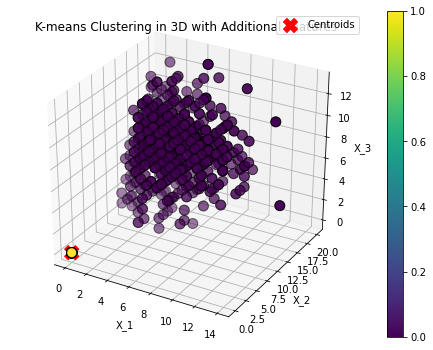

In [45]:
#Create the function for kmeans
def kmeans(data, k, max_iters=100):
    n_samples, n_features = data.shape
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    
    for _ in range(max_iters):
        # Assign each data point to the nearest centroid
        labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
        
        # Update centroids based on the mean of assigned points
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

#Create x using x_1, x_2, and x_3
x_1 = [] # Bangs
x_2 = [] # Big Nose
x_3 = [] # Goatee
for i in range(train_y.size):
    x_1.append(train_x[i][1])
    x_2.append(train_x[i][2])
    x_3.append(train_x[i][3])
x_1
x_2
x_3
observations_x = np.column_stack((x_1, x_2, x_3))
cluster_labels_kmeans, centroids = kmeans(observations_x, 2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
scatter = ax.scatter(x_1, x_2, x_3, c=cluster_labels_kmeans, cmap='viridis', edgecolors='k', s=100)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=200, c='red', label='Centroids')

# Set labels
ax.set_title('K-means Clustering in 3D with Additional Features')
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('X_3')
ax.legend()

# Add colorbar
fig.colorbar(scatter)

plt.show()
